# Modeling Time Series Data with Recurrent Neural Networks in Keras

The goal of this lab is to build an example deep neural network that can predict future outcomes based on **time series**, or sequential, data.  

A time series is a series of data points, ordered in time. For complex systems, each data point will likely be **multivariate**, meaning there are multiple variables for each data point.  Examples of data sets with multivariate time series data are financial markets, air quality measurement, and health records.  In each case, the goal is to predict one of the variable values, such as a stock price, pollutant level, or patient outcome, based on the sequential dependence of past data.  

In this lab, you'll build a deep neural network model to predict patient mortality from time series data contained in patient records. 

The purpose of building such a model, is to provide an analytic framework that medical professionals can use to predict patient mortality at any time of interest. Such a solution provides essential feedback to clinicians when trying to assess the impact of treatment decisions, or raise early warning signs to flag at-risk patients in a busy hospital care setting.

This project and patient **electronic health record (EHR)** data are provided by Children's Hospital Los Angeles (CHLA).



## Table of Contents
We will go through the following steps in this lab to recreate the CHLA project through a series of notebooks.


1. [Explore the Data with *pandas*](01_ExploreData.ipynb)<br>
    You'll learn how to:
    - Set Up the Environment<br>
    - Load the Data with *pandas*<br>
    - Visualize the Data
    - Save a *pandas* DataFrame
<br><br>
2. [Prepare the Data with *pandas* and *NumPy*](02_PrepareData.ipynb)<br>
    You'll learn how to:
    - Normalize the Data<br>
    - Fill Data Gaps<br>
    - Pad Variable Length Sequences
    - Save a *NumPy* Array
<br><br>
3. [Build a Time Series Data Model with *Keras*](03_BuildModel.ipynb)<br>
    You'll learn how to:
   - Design the LSTM Network Architecture<br>
   - Train the Model<br>
   - Evaluate the Model Using Validation Data<br>
   - Visualize the Results<br>
   - Compare Against Baselines: PRISM3 and PIM2


# 1. Explore the Data with *pandas*

Electronic Health Records (EHRs) contain a wealth of patient medical information that can:
* Save valuable time when an emergency arises
* Eliminate unnecesary treatment and tests
* Prevent potentially life-threatening mistakes
* Improve the overall quality of care a patient receives when seeking medical assistance

Children's Hospital Los Angeles (CHLA) wanted to know if the records could be mined to yield early warning signs of patients that may require extra care or an indication of the severity of a patient's illness.  In this lab we have access to the work and results of CHLA's applied use of deep neural networks on EHRs belonging to roughly 5,000 pediatric ICU patients.

We will start by exploring the data using the python library [*pandas*](http://pandas.pydata.org) to manage the dataset provided in [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) format.

1.1 [**Set Up the Environment**](#01_setup)<br>
1.2 [**Load the Data with *pandas***](#01_pandas)<br>
1.3 [**Visualize the Data**](#01_explore)<br>
&nbsp; &nbsp; &nbsp;1.3.1 [Example: View Data from a Single Encounter](#01_single)<br>
&nbsp; &nbsp; &nbsp;1.3.2 [Exercise: Observation Count Histogram](#01_ex_nobs)<br>
&nbsp; &nbsp; &nbsp;1.3.3 [Exercise: Length of PICU Stay Histogram](#01_ex_time)<br>

<a name="01_setup"></a>
## 1.1 Set Up the Environment

First, we import the libraries we need into our Python workspace.  We need *os* for access to the file system,  *NumPy* for fast array math, *pandas* for data management, and  *MatPlotLib* for visualization.

In [10]:
import os
import numpy as np
import pandas as pd              
import matplotlib.pyplot as plt 
import random

# Configure the notebook to display plots
%matplotlib inline

# Define the path to the data folder
data_dir = 'data\hx_series'

Next, specify the file paths in the data folder which contains training and validation datasets stored in HDF5 format: inputs (X) and their associated labels (y).
[HDF5](http://www.hdfgroup.org/) stands for "hierarchical data format version number 5".  The HDF format is designed specifically to store and organize large amounts of scientific data and was originally designed by the [National Center for Supercomputing Applications](https://en.wikipedia.org/wiki/National_Center_for_Supercomputing_Applications).  Common file extensions include `.hdf`, `.hdf5`, or simply `.h5`.  The HDF format has become very popular and is well maintained.  As a result, HDF5 is a flexible and robust format having API support in most languages and library compatibilty with Windows, OS X and Linux. It is important to note that HDF is a binary format and hence lacks the human readable transparency of text based CSV files.  However, HDF file format has faster performance and more efficient storage size.  It also scales well from small proof-of-concept ideas to [very large operational projects](https://www.hdfgroup.org/eos_vignette/).

In [11]:
# training data inputs: x and targets: y
x_train_path = os.path.join(data_dir, 'X_train.hdf')
y_train_path = os.path.join(data_dir, 'y_train.hdf')

# validation data inputs: x and targest: y
x_valid_path = os.path.join(data_dir, 'X_test.hdf')
y_valid_path = os.path.join(data_dir, 'y_test.hdf')

<a name="01_pandas"></a>
## 1.2 Load the Data with <i>pandas</i>
Finally, we load the data using the *pandas* API for reading in HDF files.  Python with pandas is used in a wide variety of academic and commercial domains, including finance, neuroscience, economics, statistics, advertising, web analytics, and more. The pandas library is an open source, BSD-licensed project providing easy-to-use data structures and analysis tools for the Python programming language. The pandas library features a fast and efficient DataFrame object for data manipulation with integrated indexing as well as tools for reading and writing data between in-memory data structures and different formats such as CSV and text files, Microsoft Excel, SQL databases, and the fast HDF5 format. Check out the [pandas documentation](http://pandas.pydata.org) for more info.

In [15]:
# It should take less than one minute to load the files
X_train = pd.read_hdf(x_train_path)
y_train = pd.read_hdf(y_train_path)
X_valid = pd.read_hdf(x_valid_path)
y_valid = pd.read_hdf(y_valid_path)
print('data load complete')

data load complete


<a name="01_explore"></a>
## 1.3 Visualize the Data

This electronic health records (EHR) database contains medical treatments and histories of patients collected over time. The EHRs used here consists of 10 years worth of patient encounter data in the Pediatric Intensive Care Unit (PICU) at Children's Hospital Los Angeles, curated by the virtual PICU ([vPICU](http://vpicu.net)) team. This dataset contains 1,113,529 observations among 5,000 unique patient encounters. 

<img style="float: right;" src="images/ehr.svg" width="450" height="300">
This data is an irregular time series of observations consisting of varied numbers of measurements taken over the course of a patient's stay in the PICU. Time between observations can vary from minutes to hours. A simplified diagram of the data can be seen on the right. <br>
Features (measurement types) include:

* **Statics** *(e.g. gender, age, weight)*
* **Vitals** *(e.g. heart rate, respiratory rate)*
* **Labs** *(e.g. glucose, creatinine)*
* **Interventions** *(e.g. intubation, O2)*
* **Drugs** *(e.g. dopamine, epinephrine)*

For a complete list of features, see [ehr_features.csv](csv/ehr_features.csv)

One thing to note is that in addition to the non-uniform sampling, not all measurement types were taken for all patients.

If we just have a look at the training data, it's clear that we have a collection of patient encounters with a set of variables observed at different times during each encounter.  But again, not all variables are measured at each observation time (row entry). 

The label (y) data for each patient encounter is the ultimate result of alive (1) or not alive (0). 

Let's take a look at the data.

In [16]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  ABG HCO3 (mEq/L)  \
encounterID absoluteTime                                                        
8           0.000000                          NaN       NaN               NaN   
            0.250000                          NaN       NaN               NaN   
            0.500000                          NaN       NaN               NaN   
            0.583333                          NaN       NaN               NaN   
            0.750000                          NaN       NaN               NaN   
...                                           ...       ...               ...   
16259       87.000000                         NaN       NaN               NaN   
            87.083336                         NaN       NaN               NaN   
            87.666664                         NaN       NaN               NaN   
            88.000000                         NaN       NaN               NaN   
            89.000000                         NaN       NaN               NaN   

                          ABG O2 sat (%)  ABG PCO2 (mmHg)  ABG PO2 (mmHg)  \
encounterID absoluteTime                                                    
8           0.000000                 NaN              NaN             NaN   
            0.250000                 NaN              NaN             NaN   
            0.500000                 NaN              NaN             NaN   
            0.583333                 NaN              NaN             NaN   
            0.750000                 NaN              NaN             NaN   
...                                  ...              ...             ...   
16259       87.000000                NaN              NaN             NaN   
            87.083336                NaN              NaN             NaN   
            87.666664                NaN              NaN             NaN   
            88.000000                NaN              NaN             NaN   
            89.000000                NaN              NaN             NaN   

                          ABG TCO2 (mEq/L)  ABG pH  ALT (SGPT) (units/L)  \
encounterID absoluteTime                                                   
8           0.000000                   NaN     NaN                   NaN   
            0.250000                   NaN     NaN                   NaN   
            0.500000                   NaN     NaN                   NaN   
            0.583333                   NaN     NaN                   NaN   
            0.750000                   NaN     NaN                   NaN   
...                                    ...     ...                   ...   
16259       87.000000                  NaN     NaN                   NaN   
            87.083336                  NaN     NaN                   NaN   
            87.666664                  NaN     NaN                   NaN   
            88.000000                  NaN     NaN                   NaN   
            89.000000                  NaN     NaN                   NaN   

                          AST (SGOT) (units/L)  ...  Vasopressin  Vecuronium  \
encounterID absoluteTime                        ...                            
8           0.000000                       NaN  ...          NaN         NaN   
            0.250000                       NaN  ...          NaN         NaN   
            0.500000                       NaN  ...          NaN         NaN   
            0.583333                       NaN  ...          NaN         NaN   
            0.750000                       NaN  ...          NaN         NaN   
...                                        ...  ...          ...         ...   
16259       87.000000                      NaN  ...          NaN         NaN   
            87.083336                      NaN  ...          NaN         NaN   
            87.666664                      NaN  ...          NaN         NaN   
            88.000000                      NaN  ...          NaN         NaN   
            89.000000

Notice here that there are 265 measurement variables (columns) in total.  We could also ask directly using `len(X_train.columns)`.<br>
The data imported by is a multi-index DataFrame where index "level 0" is the unique patient encounter identifier (`encounterID`) and index "level 1" is the time of each observation in units of hours since the first observation (`absoluteTime`).

Have a quick look at the label data for each patient encounter.  We see it follows the same indexing, but only contains a single binary value for each observation.

In [17]:
y_train

mortalityResponse
encounterID absoluteTime                   
8           0.000000                      1
            0.250000                      1
            0.500000                      1
            0.583333                      1
            0.750000                      1
...                                     ...
16259       87.000000                     1
            87.083336                     1
            87.666664                     1
            88.000000                     1
            89.000000                     1

[1113529 rows x 1 columns]

<a name='01_single'></a>
### 1.3.1 Example: View Data from a Single Encounter

We can look more closely at a single patient visit by specifying the `encounterID` "level 0" index.  To extract just these values, try the following:

In [18]:
X_train.index.levels[0]

Int64Index([    8,    11,    13,    15,    18,    20,    21,    23,    25,
               27,
            ...
            16233, 16236, 16241, 16243, 16244, 16248, 16250, 16254, 16255,
            16259],
           dtype='int64', name='encounterID', length=5000)

In [19]:
# Select a random patient encounterID from a list of all the encounterID values
eIdx = random.choice(list(X_train.index.levels[0]))

# Specify a few variables to look at
variables = [
    'Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)'
]

# Note that the full list of variables can be constructed using
# list(X_train.columns.values)

# Have a look at the variables for the selected patient
print('encounterID = {}'.format(eIdx))
print('number of observations = {}'.format(X_train.loc[eIdx].index.shape[0]))
print('max absoluteTime value = {} hours'.format(X_train.loc[eIdx].index[-1]))
X_train.loc[eIdx, variables]

encounterID = 3566
number of observations = 35
max absoluteTime value = 14.5 hours


,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
absoluteTime,,,,,,,,,
0.000000,14.342749,110.0,NaN,46.900000,101.000000,52.000000,16.0,5.0,2.0
0.083333,14.342758,113.0,NaN,NaN,91.000000,53.000000,19.0,NaN,NaN
0.116667,14.342762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.166667,14.342768,100.0,78.0,NaN,99.000000,52.000000,17.0,NaN,NaN
0.250000,14.342777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.583333,14.342815,88.0,80.0,46.799999,100.333333,51.666667,14.0,6.0,2.0
1.583333,14.342929,97.0,88.0,NaN,111.000000,55.000000,12.0,NaN,3.0
2.083333,14.342986,86.0,NaN,NaN,98.000000,48.000000,15.0,NaN,NaN
2.583333,14.343043,80.0,100.0,46.799999,80.333333,40.000000,12.0,6.0,3.0


To get a look at a variable for a particular patient encounter simply extract that variable from an encounter and plot it using the _pandas_ plot function.

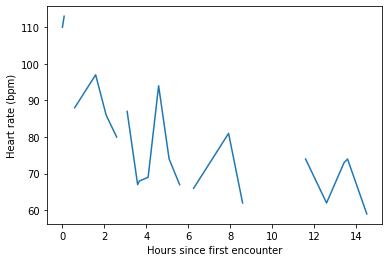

In [20]:
X_train.loc[eIdx, "Heart rate (bpm)"].plot()
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

<a name="01_ex_nobs"></a>
### 1.3.2 Observation Count Histogram

We might want to know more about the variability of the time series data. For example, how many observations are there in an encounter typically?  A histogram will provide a good visualization of how the variability in observations per patient is distributed.  To create a histogram we need to:

1. Create a list of `encounterID` values
2. Create a list of observation counts for each of these encounters
3. Create a histogram using MatplotLib  

In [21]:
# TODO Step 1 - Create a list of `encounterID` values
eIdx_list = X_train.index.levels[0]

In [23]:
# Step 2 - Create a list of observation counts for each of these encounters
# The number of observations in each encounter can be extracted as the shape of each individual encounter
nobs_list = [X_train.loc[ix].index.shape[0] for ix in eIdx_list]

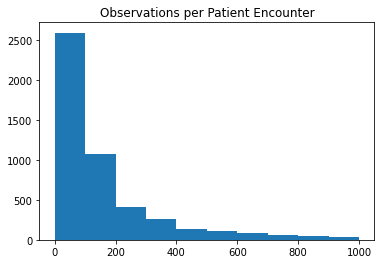

In [24]:
# Step 3 - Create a histogram using MatplotLib
plt.hist(nobs_list,range=(0,1000))
plt.title("Observations per Patient Encounter")
plt.show()

In [25]:
print('The mean = {}'.format(np.mean(nobs_list)))
print('The median = {}'.format(np.median(nobs_list)))

The mean = 222.7058
The median = 94.0


From the histogram, we can see that the observation count per patient typically falls 0 and 100.

<a name='01_ex_time'></a>
### 1.3.3 Length of PICU Stay Histogram
We can do a similar analysis to determine the observation timespan over all patient encounters.  Recall that the observation index `absoluteTime` is the cumulative time since admission to the PICU.  Therefore, the last `absoluteTime` value is the one we want to capture for each encounter.

1. Create a list of `encounterID` values
2. Create a list of `absoluteTime` final for each encounter
3. Create a histogram using MatplotLib  

In [26]:
# TODO Step 1 - Create a list of `encounterID` values
# Hint: Earlier in the section, we created this list and selected a random choice from it
eIdx_list = X_train.index.levels[0]

In [27]:
# TODO Step 2 - Create a list of `absoluteTime` final for each encounter
timespan_list = [X_train.loc[ix].index[-1] for ix in eIdx_list]

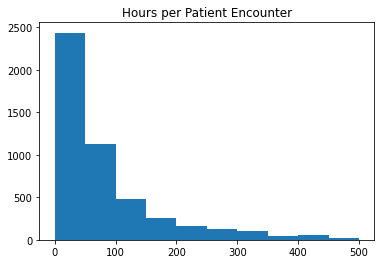

In [28]:
# Step 3 - Create a histogram using MatplotLib
plt.hist(timespan_list,range=(0,500))
plt.title("Hours per Patient Encounter")
plt.show()

Again, from the histogram, we see that total hours spent by each patient on average falls between 0 and 50.

In [29]:
print('The mean = {}'.format(np.mean(timespan_list)))
print('The median = {}'.format(np.median(timespan_list)))

The mean = 112.8358599603653
The median = 51.5


<a name="01_save"></a>
## 1.4 Save a *pandas* DataFrames

Before moving to the next notebook, save the *pandas* DataFrames to reload into the next notebook.

In [31]:
# Save the DataFrame's for use in other notebooks
X_train.to_pickle('X_train.pkl')
y_train.to_pickle('y_train.pkl')
X_valid.to_pickle('X_valid.pkl')
y_valid.to_pickle('y_valid.pkl')